In [ ]:
%matplotlib  inline 
from google.colab import drive 
drive.mount ('/gdrive') 
import sys 
sys.path.insert (0, '/gdrive/My Drive')

Mounted at /gdrive


In [ ]:
!ls "/gdrive/My Drive/resource"

bert.ipynb		       finetuned_BERT_epoch_6.model  tweet.csv
bertt.ipynb		       finetuned_BERT_epoch_7.model  twitter.csv
finetuned_BERT_epoch_10.model  finetuned_BERT_epoch_8.model  twitter.json
finetuned_BERT_epoch_1.model   finetuned_BERT_epoch_9.model  Untitled0.ipynb
finetuned_BERT_epoch_2.model   test.json		     Untitled1.ipynb
finetuned_BERT_epoch_3.model   testt.csv		     val.json
finetuned_BERT_epoch_4.model   train.json
finetuned_BERT_epoch_5.model   trainn.csv


In [ ]:
import os
os.chdir("/gdrive/My Drive/resource")

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5498407306997827745, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 802078583802085518
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
!pip install transformers[tf-cpu]
!pip install transformers[torch]
!pip install transformers[flax]
!pip install transformers==3.0.2



     |████████████████████████████████| 1.8MB 17.6MB/s 
     |████████████████████████████████| 890kB 53.1MB/s 
     |████████████████████████████████| 2.9MB 57.8MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 144.1MB 26kB/s 
     |████████████████████████████████| 14.5MB 250kB/s 
     |████████████████████████████████| 92kB 12.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1e0dbb35856ddcf7b94f27278f401b8cd246feafed79702d535d6e14a7b82286
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=ea19ef4fb3ee0a26523bdc675633e6fb3eb0ec40d22bfce818d5528e4c690c0c
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built sacremoses

     |████████████████████████████████| 31.9MB 110kB/s 
     |████████████████████████████████| 163kB 56.6MB/s 
  Found existing installation: jaxlib 0.1.59+cuda101
    Uninstalling jaxlib-0.1.59+cuda101:
      Successfully uninstalled jaxlib-0.1.59+cuda101
     |████████████████████████████████| 778kB 15.5MB/s 
     |████████████████████████████████| 3.0MB 54.3MB/s 
     |████████████████████████████████| 1.2MB 58.5MB/s 
  Found existing installation: tokenizers 0.9.4
    Uninstalling tokenizers-0.9.4:
      Successfully uninstalled tokenizers-0.9.4
  Found existing installation: transformers 4.2.2
    Uninstalling transformers-4.2.2:
      Successfully uninstalled transformers-4.2.2


In [ ]:
import json
import random
import warnings
from datetime import datetime
import transformers
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adagrad
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import class_weight
from tqdm import tqdm
 
from transformers import AutoModel, AutoTokenizer
from transformers import *
import tensorflow as tf
import tensorflow_datasets

In [ ]:
pip install transformers==3.0.2

In [ ]:
train_path = '/gdrive/My Drive/resource/train.json'
val_path = '/gdrive/My Drive/resource/val.json'
test_path = '/gdrive/My Drive/resource/test.json'

df_path='/gdrive/My Drive/resource/twitter.json'
device = 'cuda'

In [ ]:
with open(train_path, 'r') as f:
    train = json.load(f)
with open(val_path, 'r') as f:
    val = json.load(f)
with open(test_path, 'r') as f:
    test = json.load(f)

In [ ]:
def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        else:
            final_text += word+' '
    return final_text

In [ ]:
 
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-128k-uncased")
bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-128k-uncased").to(device)
 
def feature_extraction(text):
    x = tokenizer.encode(filter(text))
    with torch.no_grad():
        x, _ = bert(torch.stack([torch.tensor(x)]).to(device))
        return list(x[0][0].cpu().numpy())

In [ ]:
mapping = {'negatif':0, 'nötr':1, 'pozitif':2}
def data_prep(dataset):
    X = []
    y = []
    for element in tqdm(dataset):
        X.append(feature_extraction(element['text']))
        y_val = np.zeros(3)
        y_val[mapping[element['duygu']]] = 1
        y.append(y_val)
    return np.array(X), np.array(y)
 
X_train, y_train = data_prep(train)
X_val, y_val = data_prep(val)
X_test, y_test = data_prep(test)

100%|██████████| 1860/1860 [00:21<00:00, 85.89it/s]


In [ ]:
class_counts = [0, 0, 0]
for el in y_train:
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(768,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9

In [ ]:

history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size=64,
                    epochs=500,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    class_weight=class_weights)


Epoch 1/500
109/109 [==============================] - 3s 6ms/step - loss: 4.6426 - accuracy: 0.3434 - val_loss: 1.1277 - val_accuracy: 0.3161
Epoch 2/500
109/109 [==============================] - 1s 5ms/step - loss: 4.4823 - accuracy: 0.3458 - val_loss: 1.1067 - val_accuracy: 0.4065
Epoch 3/500
109/109 [==============================] - 0s 3ms/step - loss: 4.4634 - accuracy: 0.3418 - val_loss: 1.0969 - val_accuracy: 0.4108
Epoch 4/500
109/109 [==============================] - 0s 3ms/step - loss: 4.4365 - accuracy: 0.3386 - val_loss: 1.0447 - val_accuracy: 0.4473
Epoch 5/500
109/109 [==============================] - 0s 3ms/step - loss: 4.4738 - accuracy: 0.3420 - val_loss: 1.0648 - val_accuracy: 0.4430
Epoch 6/500
109/109 [==============================] - 0s 3ms/step - loss: 4.5238 - accuracy: 0.3122 - val_loss: 1.0822 - val_accuracy: 0.4086
Epoch 7/500
109/109 [==============================] - 0s 3ms/step - loss: 4.3231 - accuracy: 0.3587 - val_loss: 1.0685 - val_accuracy: 0.4280

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 0.4399
Testing Accuracy:  0.4022


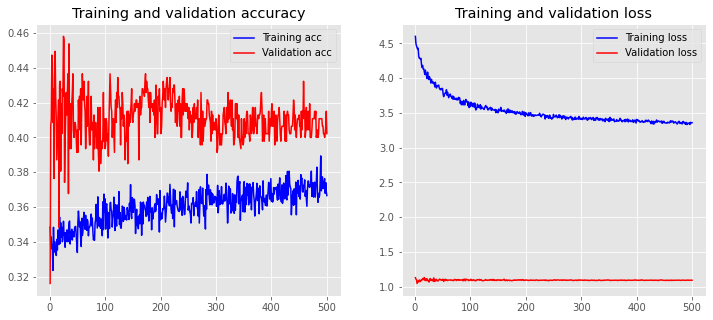

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
y_true, y_pred = np.argmax(y_test, 1), np.argmax(model.predict(X_test), 1)
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.535     0.457     0.493       912
           1      0.196     0.278     0.230       378
           2      0.343     0.328     0.335       570

    accuracy                          0.381      1860
   macro avg      0.358     0.354     0.353      1860
weighted avg      0.407     0.381     0.391      1860



In [ ]:

report = pd.DataFrame(classification_report(y_true,y_pred, output_dict=True))

In [ ]:

report = report.rename(columns={'0':'negatif', '1':'nötr', '2':'pozitif'})

In [ ]:
report

,negatif,nötr,pozitif,accuracy,macro avg,weighted avg
precision,0.534615,0.196262,0.343119,0.381183,0.357999,0.407169
recall,0.457237,0.277778,0.328070,0.381183,0.354362,0.381183
f1-score,0.492908,0.230011,0.335426,0.381183,0.352782,0.391220
support,912.000000,378.000000,570.000000,0.381183,1860.000000,1860.000000
